# Tutorial 4b: Parameter estimation with Markov chain Monte Carlo

(c) 2016 Justin Bois. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This tutorial was generated from an Jupyter notebook.  You can download the notebook [here](t4b_param_est_with_mcmc.ipynb). You can also view it [here](https://nbviewer.jupyter.org/url/bebi103.caltech.edu/2016/tutorials/t4b_param_est_with_mcmc.ipynb).*

In [120]:
import collections
import itertools
import math

import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.tools.numdiff as smnd
import numba

# Our main MCMC package
import emcee

# Corner is useful for displaying MCMC results
import corner

# BE/Bi 103 utils
import bebi103

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Some pretty Seaborn settings
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)

# Make Matplotlib plots appear inline
%matplotlib inline

In this tutorial, we will learn how to use **Markov chain Monte Carlo** to do parameter estimation.  To get the basic idea behind MCMC, imagine for a moment that we can draw samples out of the posterior distribution.  This means that the probability of choosing given values of a set of parameters is proportional to the posterior probability of that set of values.  If we drew many many such samples, we could reconstruct the posterior from the samples, e.g., by making histograms.  That's a big thing to image: that we can draw properly weighted samples.  But, it turns out that we can! That is what MCMC allows us to do.

We will discuss the theory behind this seemingly miraculous capability in lecture.  For this tutorial, we will just use the fact that we can do the sampling to learn about posterior distributions in the context of parameter estimation.

## Our MCMC engines

We will use the [`emcee` package](http://dan.iel.fm/emcee/current/) (formerly known as "MCMC Hammer," clearly the best name of a software package ever) to do our sampling by MCMC and will make use of the [`corner` package](http://corner.readthedocs.io/en/latest/) for display. I am a big fan of both of these packages, both of which were written by [Dan Foreman-Mackey](http://dan.iel.fm).

You will need to install both of these for this tutorial and throughout the course. You can do this using `pip`. At the command line do the following:

    pip install emcee
    pip install corner
    
We will use this software extensively in this class. If you do use it in your research, be sure to cite both [emcee](https://arxiv.org/abs/1202.3665) and [corner](http://joss.theoj.org/papers/10.21105/joss.00024).

## BE/Bi 103 utilities

In this tutorial, we will also start using a set of utilities I have written for the class. These are available from a public GitHub repository. To get it on your local machine, navigate to the directory where you want to keep it, and do the following at the command line.

    git clone https://github.com/justinbois/bebi103_utils.git
    
You should then add the path to the `bebi103/` directory to your `PYTHONPATH`. You can do this by adding the following to your relevant rc file (such as `~/.bashrc`).

    export PYTHONPATH=:.:$HOME/git/bebi103_utils
    
where in my case I was in the directory `~/git/` when I cloned the repository.

We will use many of these utilities throughout the course. A warning though: Embarrassingly, these utilities are not even close to being properly unit tested. So, you should use caution when using these utilities in real research applications until I get them thoroughly unit tested.

## The data set

We will use the data set from the [previous tutorial](t4a_param_est_mle.html) from Singer, et al., while it is still fresh in our minds.  We can borrow the log posterior functions we coded up in that tutorial for use here.  First, we'll load in the data.

In [2]:
# Load DataFrame
df = pd.read_csv('../data/singer_transcript_counts.csv', comment='#')

As a reminder, here are the ECDFs.

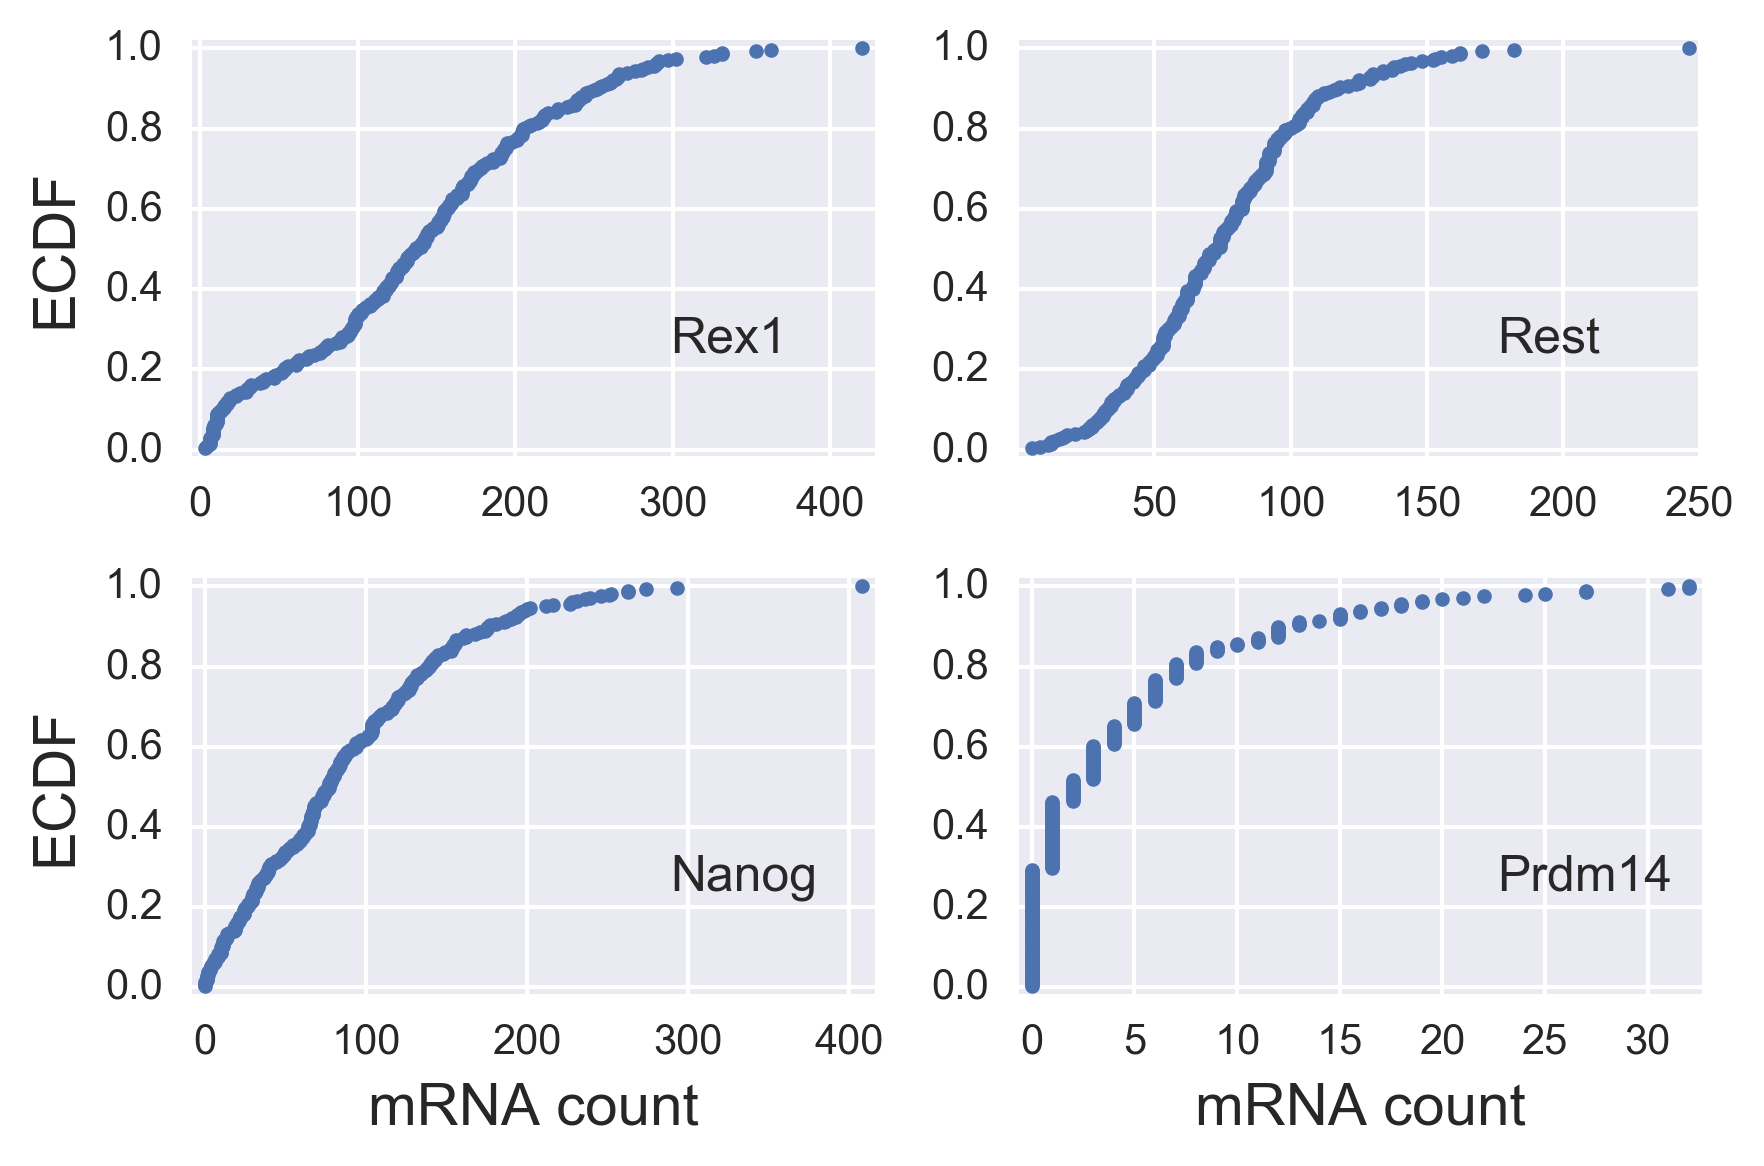

In [3]:
fig, ax = plt.subplots(2, 2)
sp_inds = list(itertools.product([0,1], [0,1]))

for i, gene in enumerate(df.columns):
    # Build ECDF
    x, y = bebi103.ecdf(df[gene])
    
    # Plot
    ax[sp_inds[i]].plot(x, y, '.')
    ax[sp_inds[i]].text(0.7, 0.25, gene, transform=ax[sp_inds[i]].transAxes,
                       fontsize=12)
    ax[sp_inds[i]].margins(0.02)
    
# Clean up
for i in [0,1]:
    ax[1,i].set_xlabel('mRNA count')
    ax[i,0].set_ylabel('ECDF')
plt.tight_layout()

We also need to specify the maximum value of $r$ we can have for our analysis, since we need it to specify the prior.

In [4]:
r_max = 20

## The posterior

We derived last time that the posterior distributions for a single negative binomial and double-binomial model are respectively

\begin{align}
P(r, p \mid \mathbf{n}) &\propto \prod_{n\in\mathbf{n}} \frac{(n + r - 1)!}{n!(r-1)!}\,p^r(1-p)^n,\\[2em]
P(r_1, r_2, p_1, p_2, f\mid n) &\propto 
f\,\frac{(n + r_1 - 1)!}{n!\,(r_1-1)!}\,p_1^{r_1}(1-p_1)^{n} \\[1em]
&\;\;\;\;+ (1-f) \frac{(n + r_2 - 1)!}{n!\,(r_2-1)!}\,p_2^{r_2}(1-p_2)^{n}.
\end{align}

As with our quest to find the MAP by optimization, we need to code up the log posterior for MCMC.  Conveniently, `emcee` uses the same API for the posterior definition as the `scipy.optimize` does.  We will again specify that $p_1 > p_2$.

In [31]:
def log_likelihood(params, n):
    """
    Log likelihood for MLE of Singer data.
    """
    r, p = params

    return np.sum(st.nbinom.logpmf(n, r, p))


def log_prior(params, r_max):
    """
    Log prior for MLE of Singer data.
    """
    r, p = params
    
    # Zero probability of having p < 0 or p > 1
    if p < 0 or p > 1:
        return -np.inf
    
    # Zero probability of r < 1
    if r <= 0 or r > r_max:
        return -np.inf

    return -np.log(r_max - 1)


def log_posterior(params, n, r_max):
    """
    Log posterior for the Singer data.
    """
    # Compute log prior
    lp = log_prior(params, r_max)

    # If log prior is -inf, return that
    if lp == -np.inf:
        return -np.inf

    # Compute and return posterior
    return lp + log_likelihood(params, n)


def log_likelihood_bimodal(params, n):
    """
    Log likelihood for linear combination of neg. binomials.
    """
    r_1, r_2, p_1, p_2, f = params
    
    return np.sum(np.log(f * st.nbinom.pmf(n, r_1, p_1)
                  + (1-f) * st.nbinom.pmf(n, r_2, p_2)))


def log_prior_bimodal(params, r_max):
    """
    Log prior for linear combination of neg. binomials.
    """
    r_1, r_2, p_1, p_2, f = params
    
    test = (f <= 0) or (f >= 1) or (r_1 <= 0) or (r_2 <= 0) or (p_1 < p_2) \
                   or (p_2 < 0) or (p_1 > 1) or (r_1 > r_max) or (r_2 > r_max)

    if test:
        return -np.inf
    
    return -2 * np.log(r_max - 1)


def log_posterior_bimodal(params, n, r_max):
    """
    Log posterior for the Singer data for lin. comb. of neg. binom
    """
    # Compute log prior
    lp = log_prior_bimodal(params, r_max)

    # If log prior is -inf, return that
    if lp == -np.inf:
        return -np.inf

    # Compute and return posterior
    return lp + log_likelihood_bimodal(params, n)


def neg_log_posterior_bimodal(params, n, r_max):
    """
    Negative log posterior for linear combination of neg. binomials.
    """
    return -log_posterior_bimodal(params, n, r_max)

## Sampling the posterior with MCMC

We now set up the Markov chain Monte Carlo calculation.  MCMC works by having a "walker" move around parameter space.  I.e., a walker samples the posterior by jumping from one set of parameter values to another with the appropriate probabilistic weighting of the jumps.  The algorithm employed by `emcee`, [the affine invariance MCMC sampler](http://msp.berkeley.edu/camcos/2010/5-1/p04.xhtml) relies on multiple walkers sampling in parallel.  We therefore have to specify how many walkers we want.  It is usually a good idea to have many, like at least twice the number of parameters, walkers for this algorithm.  In addition to the number of walkers, we also need to specify
* The number of parameters in the posterior.
* The number of "burn" steps.  You want the walkers to be sampling properly, and you don't know where to start them to do so, you throw out the first set of samples.  These are called burn steps, and the process is called "burning in" the walkers.
* The number of steps to take after burn-in.

So, let's specify these are we set up our calculation.

In [99]:
n_dim = 2        # number of parameters in the model (r and p)
n_walkers = 50   # number of MCMC walkers
n_burn = 1000    # "burn-in" period to let chains stabilize
n_steps = 1000   # number of MCMC steps to take after burn-in

Next, for consistency, I will seed the random number generator so we can compare our results as we go through the tutorial.

In [100]:
np.random.seed(42)

Now, we need to specify where in parameter space we will start each of our 50 walkers.  We will randomly draw the starting point for $p$ out of a uniform distribution on $[0,1]$.  Because we expect $r$ values pretty far from $r_\mathrm{max}$, since it was a bit upper bound, we will choose our starting $r$ values from an Exponential distribution with a mean of 1. Though we've made this choice, we could choose many other starting points.  We could, for example, find the MAP, and then start our walkers from its vicinity.  This is often done to reduce burn-in time.

In [101]:
# p0[i,j] is the starting point for walk i along variable j.
p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.exponential(1, n_walkers)       # r
p0[:,1] = np.random.uniform(0, 1, n_walkers)        # p

# Make sure we didn't by change pick an r that was too big
p0[:,0] = np.minimum(p0[:,0], r_max)

Now we are ready to instantiate our sampler, an `emcee.EnsembleSampler` instance.  The syntax is straightforward.  It takes as required arguments the number of walkers, the number of dimensions (that is, the number of parameters), and a function giving the log of the posterior.  The kwarg `args` is as in `scipy.optimize.minimize()`; it is a tuple of other arguments to be passed into your log posterior function.  These arguments almost always include your data.  Finally, the `threads` kwarg is useful.  You can specify how many cores of your machine you want to use for the calculation, and the MCMC sampling will be done with parallel processing.  It is a good idea to choose two less than the number of cores you have on your machine.  For me, I choose six threads.

For this example, we will look at the Prdm14 expression. It is important to pass the *values* of a slice from a `DataFrame`, since the Numpy array gives better computational performance.

In [102]:
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior_numba, 
                                args=(df['Prdm14'].values, r_max), threads=6)

Now, we'll do the burn-in.  This is just using the `run_mcmc()` method of the sampler without storing the results.  The first argument to the `run_mcmc()` method is the starting point of the parameter values.  The second is the number of MCMC steps to take (in this case `n_burn`).  We use the kwarg `storechain=False` to indicate that we are not saving the samples.  The sample outputs the ending position (set of parameter values), probability (posterior probability), and the state of the random number generator.  We need to keep the positions of the walkers because this is where we start after burn-in.

In [103]:
# Do burn-in
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

Now that burn-in is complete, we can run the sampler to generate the MCMC samples!

In [104]:
# Sample again, starting from end burn-in state
_ = sampler.run_mcmc(pos, n_steps)

## Parsing MCMC results

The `sampler` object has lots of properties and methods that are useful to us.  The most useful are `sampler.chain` and `sampler.flatchain`, which are the samples themselves.  You can read [the documentation](The `sampler` object has lots of properties and methods that are useful to us.  The most useful are `sampler.chain` and `sampler.flatchain`, which are the samples themselves.  You can read [the documentation](http://dan.iel.fm/emcee/current/api/#the-affine-invariant-ensemble-sampler) about these, but I find it is easier to work with the samples in a Pandas `DataFrame`. I wrote a utility function to convert a about these, but I find it is easier to work with the samples in a Pandas `DataFrame`. I wrote a utility function to convert the chain stored in the sampler instance to a `DataFrame`. You just need to specify the name of the parameters.

In [105]:
# Conver sampler output to DataFrame
df_mcmc = bebi103.sampler_to_dataframe(sampler, columns=['r', 'p'])

# Take a look
df_mcmc.head()

,r,p,lnprob,chain
0,0.562579,0.118078,-716.461960,0
1,0.560166,0.122712,-717.150879,0
2,0.560166,0.122712,-717.150879,0
3,0.556481,0.121336,-717.029080,0
4,0.556481,0.121336,-717.029080,0


As we can see, the `DataFrame` has the values of each parameter for each sample, as well as the log probability of the posterior and the ID of the chain. Since we have 50 walkers in this case, we have 50 chains.

Let's look at the trace of a single walker for each of our two parameters ($r$ and $p$).

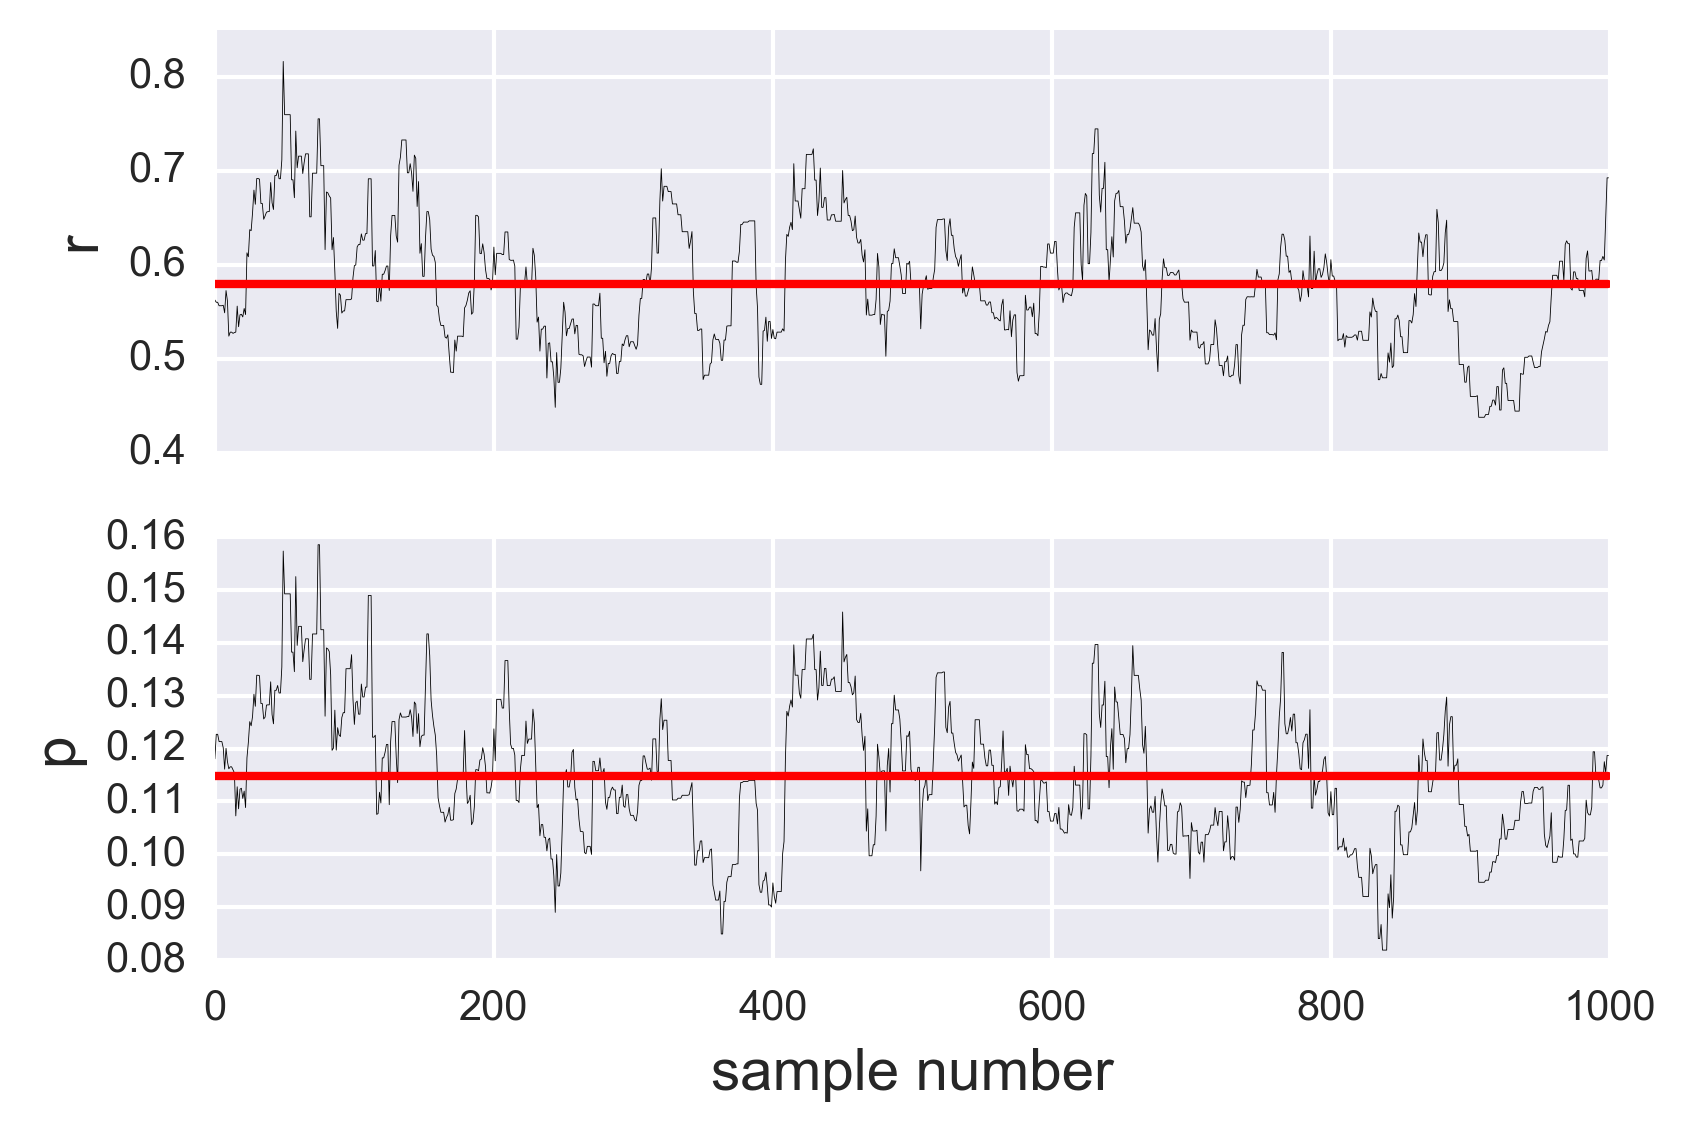

In [106]:
fig, ax = plt.subplots(2, 1, sharex=True)
for i, var in enumerate(['r', 'p']):
    # Extract walker's chain
    chain = df_mcmc.loc[df_mcmc['chain']==0, var].values

    # Plot trace and mean
    ax[i].plot(chain, 'k-', lw=0.2)
    ax[i].plot([0, len(chain)-1], np.mean(chain) * np.ones(2), 'r-')

ax[1].set_xlabel('sample number')
ax[0].set_ylabel('r')
ax[1].set_ylabel('p');

The samplers fluctuate around the mean, which is a sign, but definitely not a guarantee, that the sampler has converged, i.e., that it is accurately sampling the posterior.

Now that we know how to access the MCMC samples, let's start learning some more about our posterior. For example, we can approximate the MAP as the parameter values that were visited by the sampler that had the highest probability.

In [107]:
# Get the index of the most probable parameter set
max_ind = df_mcmc['lnprob'].idxmax()

# Pull out values.
r_MAP, p_MAP = df_mcmc.loc[max_ind, ['r', 'p']]

# Print the results
print("""
Most probable parameter values:
r: {0:.3f}
p: {1:.3f}
""".format(r_MAP, p_MAP))


Most probable parameter values:
r: 0.553
p: 0.109



These are identical to [what we got via optimization](t4a_param_est_mle.html#Numerical-optimization-to-find-the-MAP)!

But we did a lot of work to do these calculations. Let's take full advantage of them!

An obvious thing to do is to compute an error bar. If make the assumption (as before) that the posterior is approximately Gaussian, then the error bar is just given by the standard deviation of this Gaussian.  Since we have so many samples, this is just the standard deviation of all the samples! (Note: One of the main reasons we did MCMC is so that we do not have to make approximations about things being Gaussian, so we get more information from actually plotting the posterior or computing percentile-based confidence intervals, which we will talk about later.)

In [108]:
# Compute error bars by taking standard deviation
r_err, p_err = df_mcmc[['r', 'p']].std()

print("""
Error bars:
r: {0:.3f}
p: {1:.3f}
""".format(r_err, p_err))


Error bars:
r: 0.058
p: 0.013



These are quite close to [what we got via optimization](t4a_param_est_mle.html#Numerical-optimization-to-find-the-MAP).  This suggests that the posterior is accurately approximated by a Gaussian.

But, we have sampled the entire posterior.  We know everything!  I know, I've said that before just when we wrote down the posterior.  But now, we see one of the great powers of MCMC.  

Question: How do we get a marginalized distribution?  Answer: Ignore variables we don't care about!  Remember, the sampler considers all of the parameters as it steps through parameter space, so the influence of all parameters area always there.  We just need to slice out samples of what we want to get marginalized posteriors.  We can get the marginalized posterior of $r$ and $p$ and plot histograms.

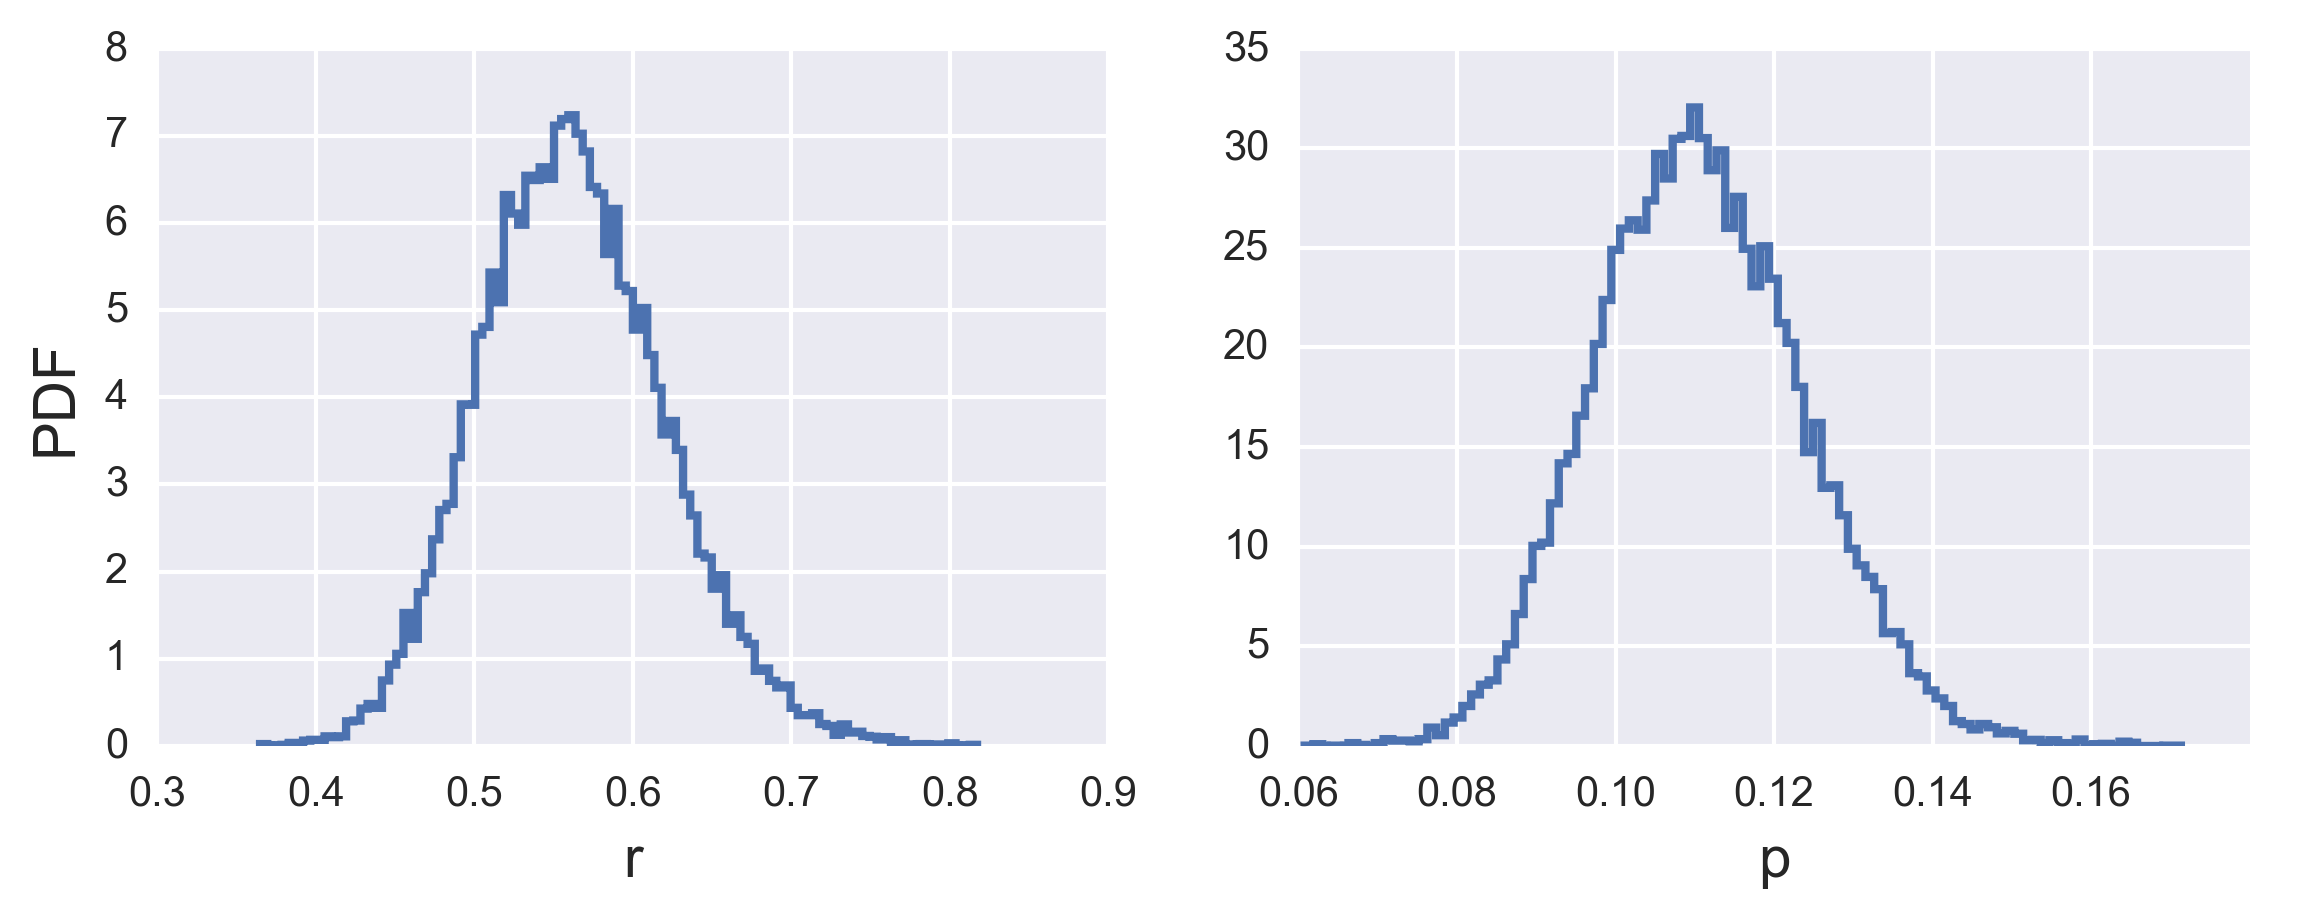

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3))

for i, var in enumerate(['r', 'p']):
    # Plot the histogram as a step plot
    _ = ax[i].hist(df_mcmc[var], bins=100, normed=True, histtype='step', lw=2)

ax[0].set_xlabel('r')
ax[1].set_xlabel('p')
ax[0].set_ylabel('PDF');

These are fine and good, but we can get a very nice summary of the posterior using the `corner` module. For this case where we have two parameters, we get the full posterior as a contour plot and the marginalized posteriors as well.

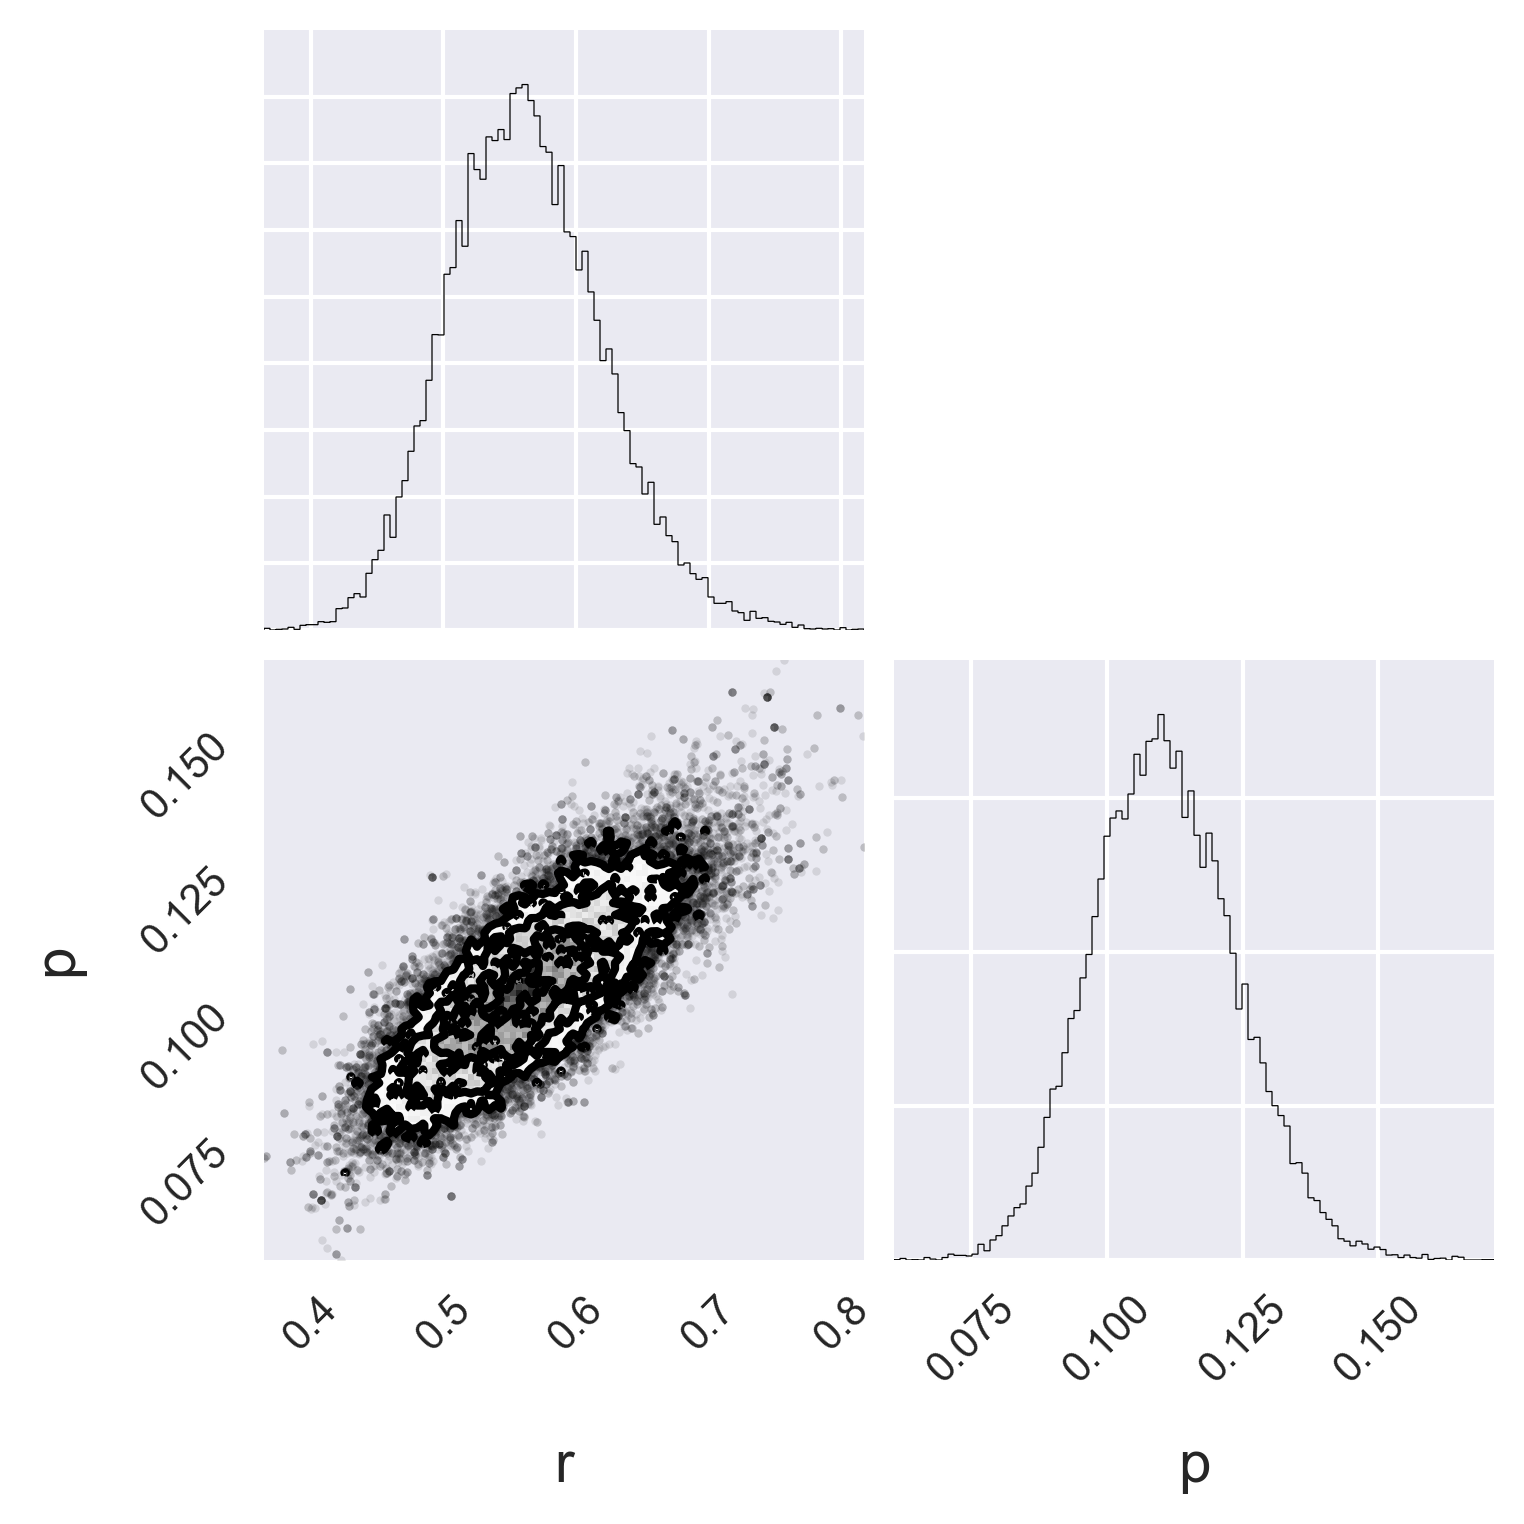

In [110]:
cols = ['r', 'p']
corner.corner(df_mcmc[cols], labels=cols, bins=100);

The scatter plot looks pretty gnarly because we didn't take too many samples, so the contour lines are jagged. We can apply smoothing to get a clearer picture using the `smooth` kwarg, which sets the standard deviation of a Gaussian filter applied to the histogram of the samples (we will talk about data smoothing later in the course).

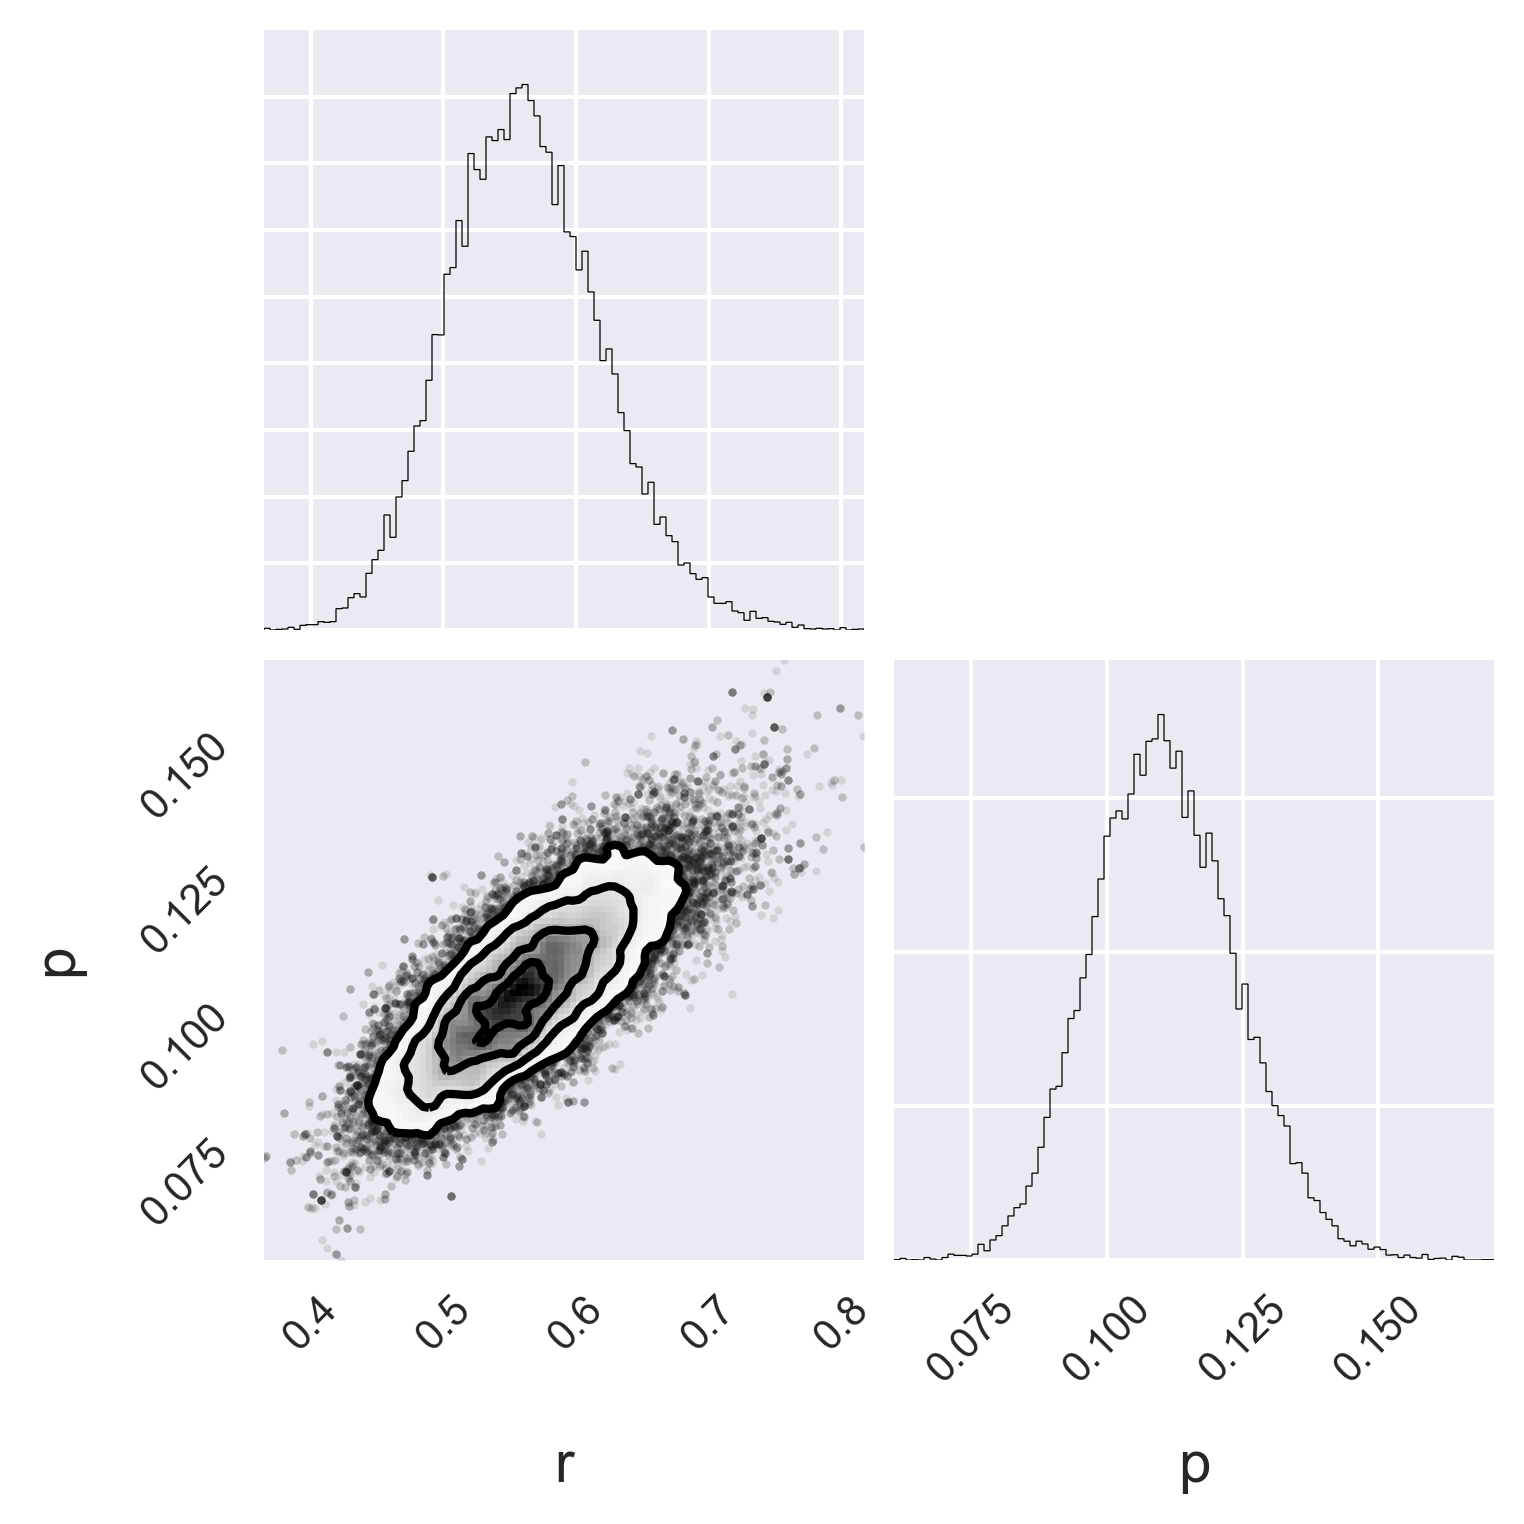

In [111]:
corner.corner(df_mcmc[cols], labels=cols, bins=100, smooth=1);

This reveals what the scatter plot in the $r$-$p$ plane is. The areas within the contours are colored according to the density of samples. The dark center has the most samples. The contour lines, going from inside to outside, capture 12%, 39%, 68%, and 86% of the samples. The scattering of points outside the contour are the remaining samples.

The diagonal plots in the corner plot are the marginalized posteriors for the individual parameters. We could smooth these as well with the `smooth1d` kwarg.

### MLE with a double negative binomial

We can repeat the analysis with the Rex1 data set using a linear combination of Negative Binomials as the likelihood. Setting up the sampler and running it can get lengthy. I wrote a convenient function to automate this a bit, `bebi103.run_ensemble_mcmc()`. This takes an ordered dictionary (instantiated with `collections.OrderedDict()` as a specification of the parameters and their initial values. Each key is the parameter name, and associated with each key is a tuple. Each entry is a tuple with the function used to generate starting points for the parameter and the arguments for the function.  The starting point function must have the call signature `f(*args_for_function, n_walkers)`. Once we have this set up, we specify the number of walkers, number of burn steps, and number of sampling steps as kwargs to `bebi103.run_ensemble_mcmc()`. The output is a `DataFrame` with our samples, log posterior values, and chain IDs.

In [19]:
# Parameters and how we start them
params = collections.OrderedDict(
        [('r1', (np.random.exponential, (1,))),
         ('r2', (np.random.exponential, (1,))),
         ('p1', (np.random.uniform, (0, 1))),
         ('p2', (np.random.uniform, (0, 1))),
         ('f', (np.random.uniform, (0, 1)))])

# Obtain samples
df_mcmc = bebi103.run_ensemble_emcee(
    log_post=log_posterior_bimodal, n_burn=5000, n_steps=5000,
    n_walkers=50, p_dict=params, args=(df['Rex1'].values, r_max), threads=6)

/Users/Justin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:49: RuntimeWarning: divide by zero encountered in log
/Users/Justin/anaconda/lib/python3.5/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/Justin/anaconda/lib/python3.5/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Let's just cut to the chase and look at the corner plot.

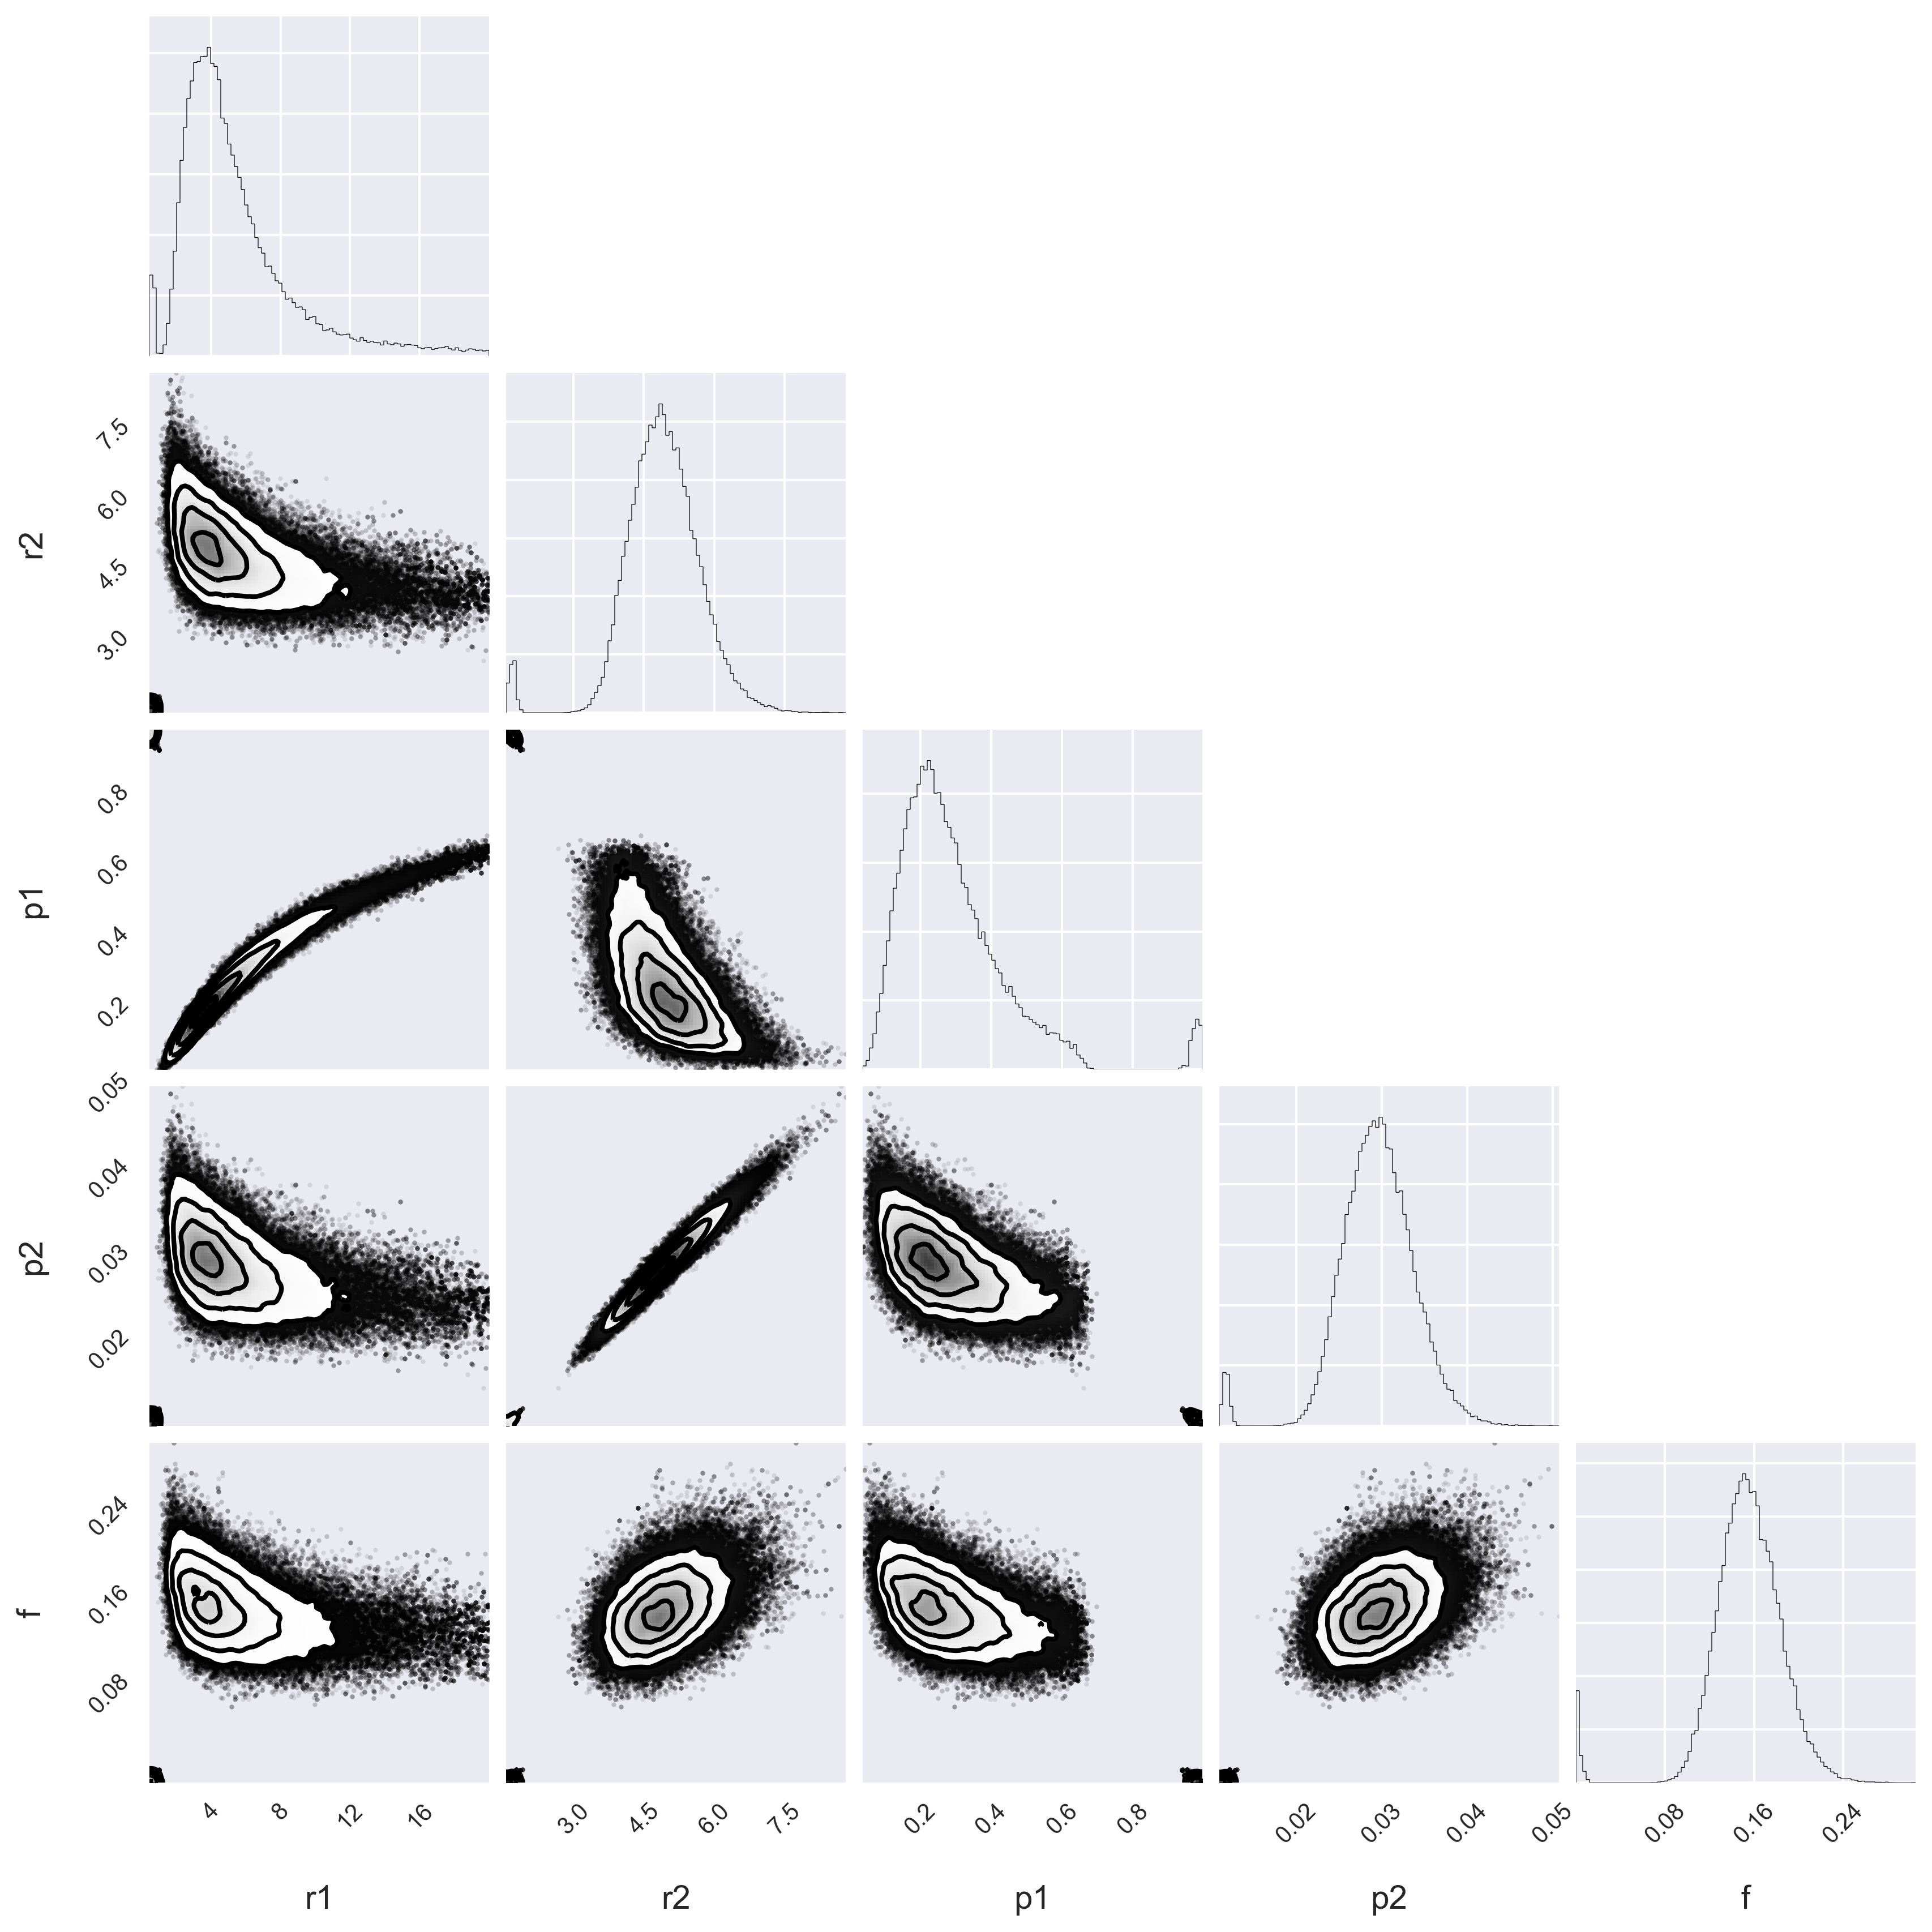

In [20]:
cols = list(params.keys())
corner.corner(df_mcmc[cols], labels=cols, bins=100, smooth=1);

First off, the small set of samples away from the rest is a sign that one or a few of the walkers was not completely burned in. For the purposes of expedience in the tutorial, we are taking few samples and even fewer burn-in steps. You can fix this by boosting `n_burn`.

We notice very strong correlation between $p_2$ and $r_2$, and also between $p_1$ and $r_1$.  We also see some strongly non-Gaussian shapes to the posteriors in the contour plots.  We also start to see tails in the marginalized posteriors.  These are all immediately apparent from the MCMC samples, further demonstrating its tremendous utility.

## A note on speed

The MCMC calculations can get long. Speed becomes an important consideration. One way to speed things up is to use the fabulous [Numba package](http://numba.pydata.org), which allows for just-in-time (JIT) compilation of functions. You can convert your Python function for the log posterior into compiled code, which typically runs faster, even than when using NumPy functions.

It is often as simple as putting a `@numba.jit()` decorator on top of your functions. However, numba only supports a subset of NumPy functions and features of the Python programming language, see [here](http://numba.pydata.org/numba-doc/dev/reference/pysupported.html) and [here](http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html).

Unfortunately, it does support anything from the `scipy.stats` module, so we'll have to hand-code our Negative Binomial PMF.

In [126]:
@numba.vectorize([numba.float64(numba.float64)],nopython=True)
def lngamma(x):
    """
    Log of Gamma function.
    """
    if x < 0.0:
        return 0.0
    return math.lgamma(x)


@numba.vectorize([numba.float64(numba.int64, numba.float64, numba.float64)],
                 nopython=True)
def nbinom_logpmf(n, r, p):
    """
    Negative binomial PMF evaluated a n-values for a given r, p.
    """
    return lngamma(n+r) - lngamma(n+1) - lngamma(r) \
                    + n * np.log(1-p) + r * np.log(p)

Here, we have used the [`numba.vectorize()` decorator](http://numba.pydata.org/numba-doc/dev/user/vectorize.html). Now, we can code up our log likelihood and log prior. We do not JIT the log posterior function because the JITted function object cannot be pickled. This means that we cannot use multiple threads if we JIT the log posterior. The speed loss is negligible, since the likelihood is by far the most expensive calculation.

In [133]:
@numba.jit(nopython=True)
def log_likelihood_numba(params, n):
    """
    Log likelihood for MLE of Singer data.
    """
    r, p = params
    return np.sum(nbinom_logpmf(n, r, p))


@numba.jit(nopython=True)
def log_prior_numba(params, r_max):
    """
    Log prior for MLE of Singer data.
    """
    r, p = params
    
    # Zero probability of having p < 0 or p > 1
    if p < 0 or p > 1:
        return -np.inf
    
    # Zero probability of r < 1
    if r <= 0 or r > r_max:
        return -np.inf

    return -np.log(r_max - 1)


def log_posterior_numba(params, n, r_max):
    """
    Log posterior for the Singer data.
    """
    # Compute log prior
    lp = log_prior_numba(params, r_max)

    # If log prior is -inf, return that
    if lp == -np.inf:
        return -np.inf

    # Compute and return posterior
    return lp + log_likelihood_numba(params, n)

Now let's test the speed of the JITted version versus the original one we used.

In [137]:
r = 0.1
p = 0.3

%timeit log_posterior((r, p), df['Prdm14'].values, r_max)
%timeit log_posterior_numba((r, p), df['Prdm14'].values, r_max)

10000 loops, best of 3: 175 µs per loop
10000 loops, best of 3: 38.6 µs per loop


This is a speed boost of about 4.5 fold. This is valuable. There is a big difference between a calculation that takes 10 minutes versus 45 minutes.